# Workflow

1. Create a function that takes a tuple of two images and returns a tuple of the same two cropped (or, equivalently, a patch from the) images, where the cropped images are of the same randomly determined location.
2. Verify that this was implemented correctly by visualizing the output images as in the previous module.
Create a class that inherits from Dataset to handle the NIfTI files. Implement the following methods:
    -  \_\_init\_\_
    - \_\_len\_\_
    - \_\_getitem\_\_


In [262]:
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import os
import random
from random import randint
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os, os.path
import torch
%matplotlib inline

In [12]:
train_dir = "..\small"
t1_dir = os.path.join(train_dir, 't1')
t2_dir = os.path.join(train_dir, 't2')
file_names_t1 = glob.glob(os.path.join(t1_dir,"*.nii.*"))
file_names_t2 = glob.glob(os.path.join(t2_dir,"*.nii.*"))
assert len(file_names_t1) == len(file_names_t2) and len(file_names_t1) > 0

In [280]:
def showPairImages(source, target):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
  
    ax1.imshow(source[60,:,:], cmap='gray'); ax1.set_title('T1 shape:{}'.format(source.shape),fontsize=22); ax1.axis('on'); 
    ax2.imshow(target[60,:,:], cmap='gray'); ax2.set_title('T2 shape:{}'.format(target.shape),fontsize=22); ax2.axis('on'); 

Random index: 15, T1 : IXI160-HH-1637-T1_fcm.nii.gz, T2 : IXI160-HH-1637-T2_reg_fcm.nii.gz


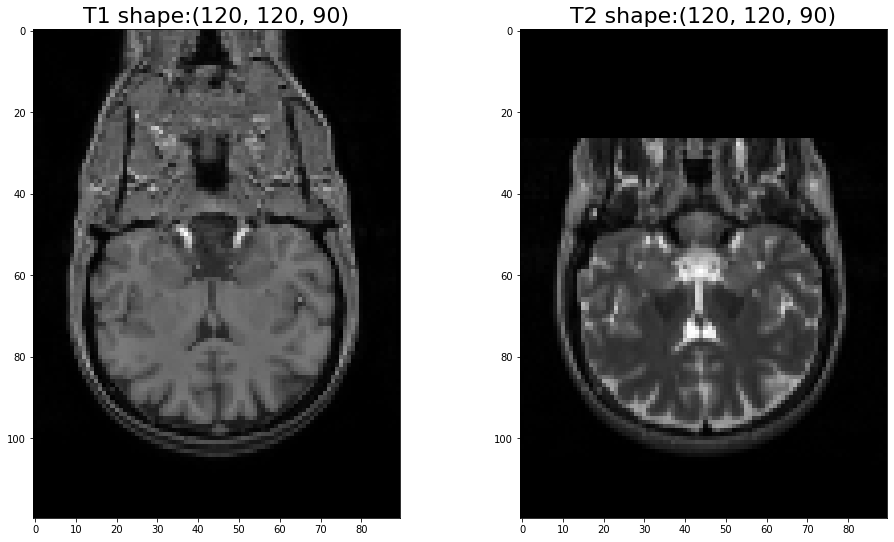

In [281]:
random_idx = randint(0,len(file_names_t1))
t1_image = file_names_t1[random_idx]
t2_image = file_names_t2[random_idx]
print('Random index: {}, T1 : {}, T2 : {}'.format(random_idx,os.path.basename(t1_image), os.path.basename(t2_image )))

nib_t1 = nib.load(t1_image).get_fdata()
nib_t2 = nib.load(t2_image).get_fdata()
showPairImages(nib_t1,nib_t2)


In [312]:
class RandomCrop3D:
    def __init__(self, args):
        assert isinstance(args, (int, tuple))
        if isinstance(args, int):
            self.output_size = (args, args, args)
        else:
            assert len(args) == 3
            self.output_size = args

    def __call__(self, sample):
        assert len(sample) == 2
        t1, t2 = sample
        
        #crop
        x, y, z = self.output_size
        orig_x, orig_y, orig_z = t1.shape
        x_start = randint(0, orig_x - x)
        y_start = randint(0, orig_y - y)
        z_start = randint(0, orig_z - z)
        
        t1 = t1[x_start:x_start + x , y_start:y_start + y, z_start:z_start + z]
        t2 = t2[x_start:x_start + x , y_start:y_start + y, z_start:z_start + z]
        return t1, t2

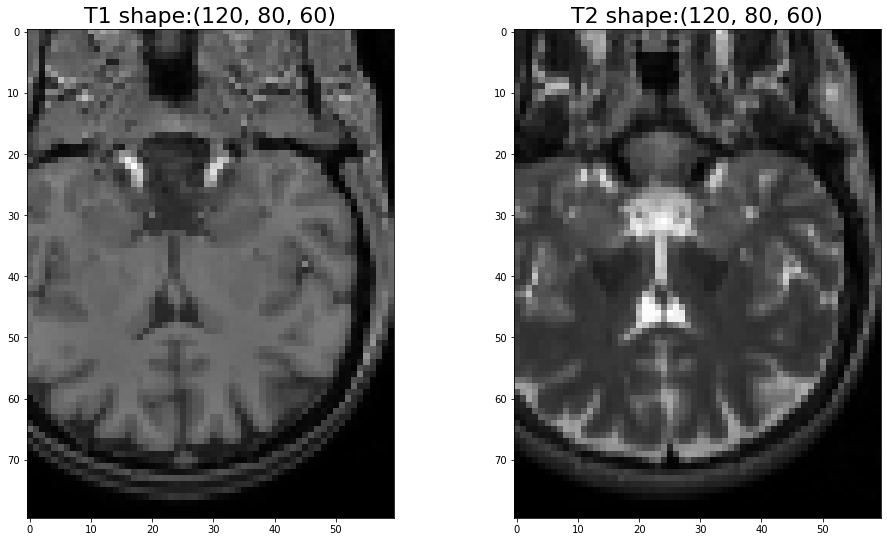

In [313]:
nib_cropped_t1, nib_cropped_t2 = RandomCrop3D((120,80,60))((nib_t1, nib_t2))
showPairImages(nib_cropped_t1, nib_cropped_t2)

In [297]:
class NiftiDataset(Dataset):
    def __init__(self, source_dir, target_dir, transforms = None):
        self.file_names_source = glob.glob(os.path.join(source_dir,"*.nii.*"))
        self.file_names_target = glob.glob(os.path.join(target_dir,"*.nii.*"))
        assert len(self.file_names_source) == len(self.file_names_target)
        
        self.transforms = transforms

    def __len__(self):
        return len(self.file_names_source)
    
    
    def __getitem__(self, idx):
        source = nib.load(self.file_names_source[idx]).get_fdata()
        target = nib.load(self.file_names_target[idx]).get_fdata()
        
        if self.transforms:
            source, target = self.transforms((source,target))
        
        return source, target

In [175]:
train_dir = "..\small"
t1_dir = os.path.join(train_dir, 't1')
t2_dir = os.path.join(train_dir, 't2')

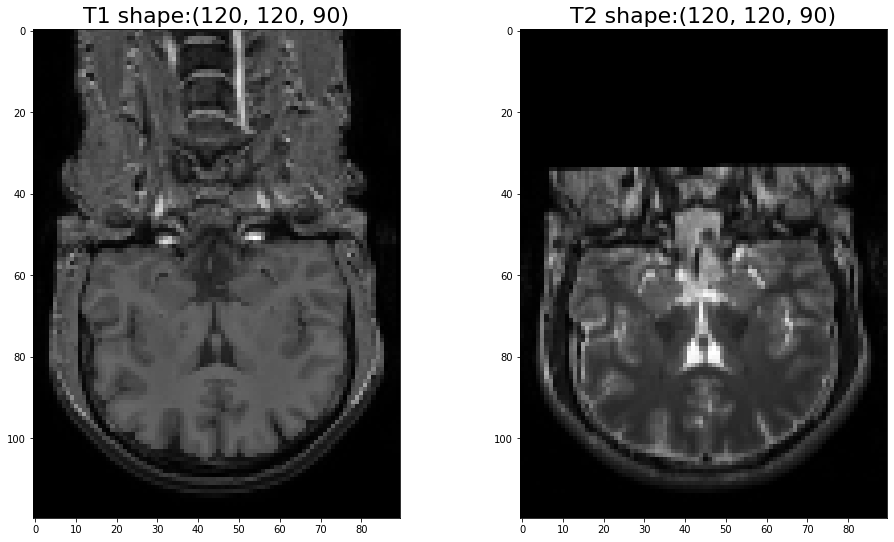

In [298]:
nifti_dataset = NiftiDataset(t1_dir,t2_dir)
source, target = nifti_dataset[9]
showPairImages(source, target)

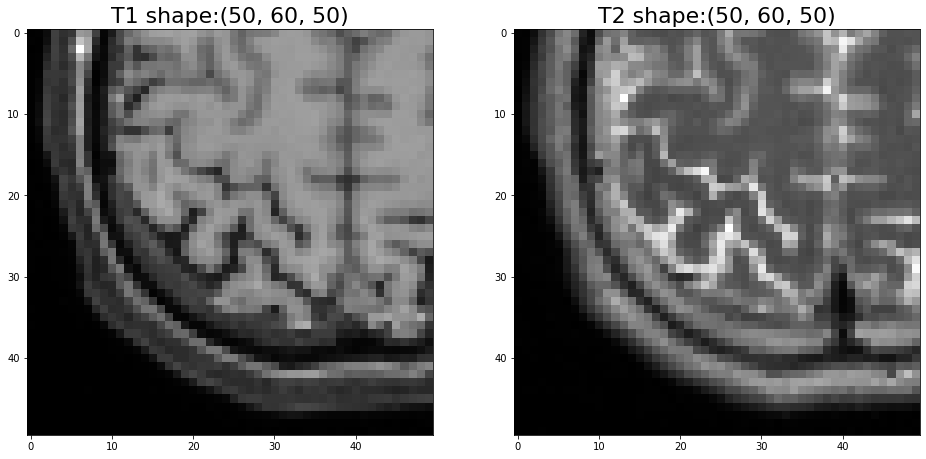

In [256]:
nib_cropped_t1, nib_cropped_t2 = RandomCrop3D((50, 60, 50))((source, target))
showPairImages(nib_cropped_t1, nib_cropped_t2)

<Figure size 432x288 with 0 Axes>

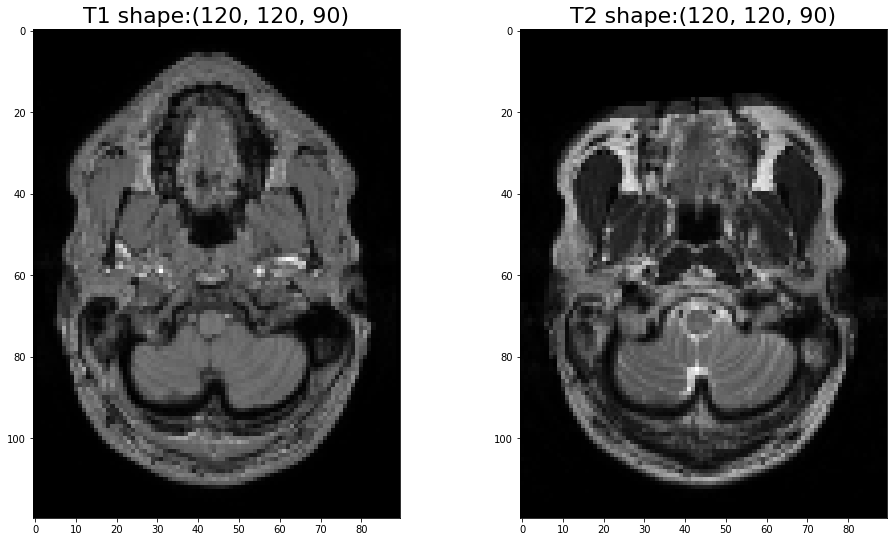

In [272]:
composed = transforms.Compose([RandomCrop3D((120,120,90))])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = nifti_dataset[9]

transformed_sample = composed(sample)

showPairImages(transformed_sample[0], transformed_sample[1])

<Figure size 432x288 with 0 Axes>

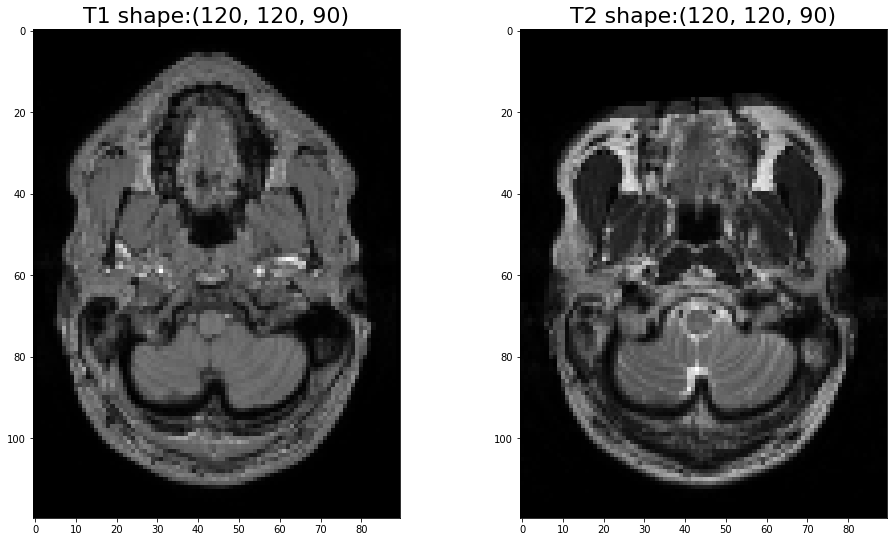

In [273]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                   root_dir='data/faces/',
                                   transform= transforms.Compose([Rescale(256),
                               RandomCrop(240),
                                   ToTensor()                               ])      )

In [314]:
class ToTensor(object):
    def __call__(self, sample):
        source, target = sample
        
        return torch.from_numpy(source), torch.from_numpy(target)

In [315]:
transformed_nifti_dataset = NiftiDataset(t1_dir,
                                         t2_dir,
                                        transforms = transforms.Compose([RandomCrop3D((90)), ToTensor()]))

0 2 torch.Size([90, 90, 90]) torch.Size([90, 90, 90])
1 2 torch.Size([90, 90, 90]) torch.Size([90, 90, 90])
2 2 torch.Size([90, 90, 90]) torch.Size([90, 90, 90])
3 2 torch.Size([90, 90, 90]) torch.Size([90, 90, 90])


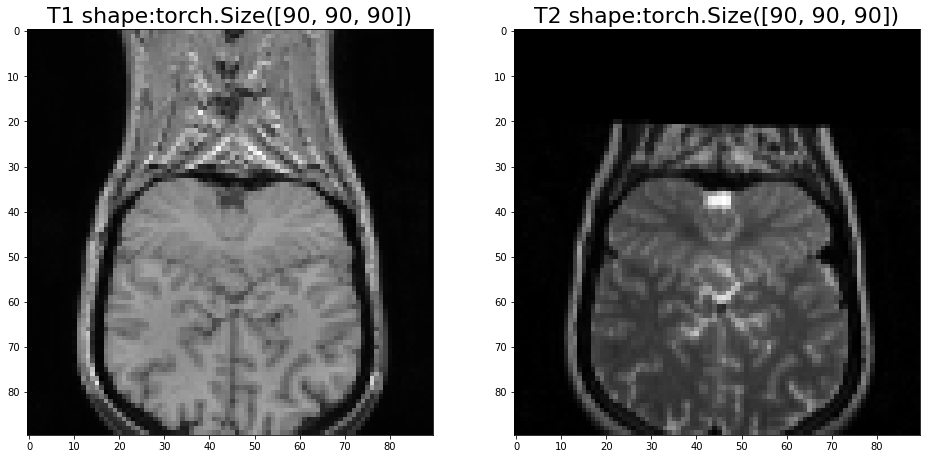

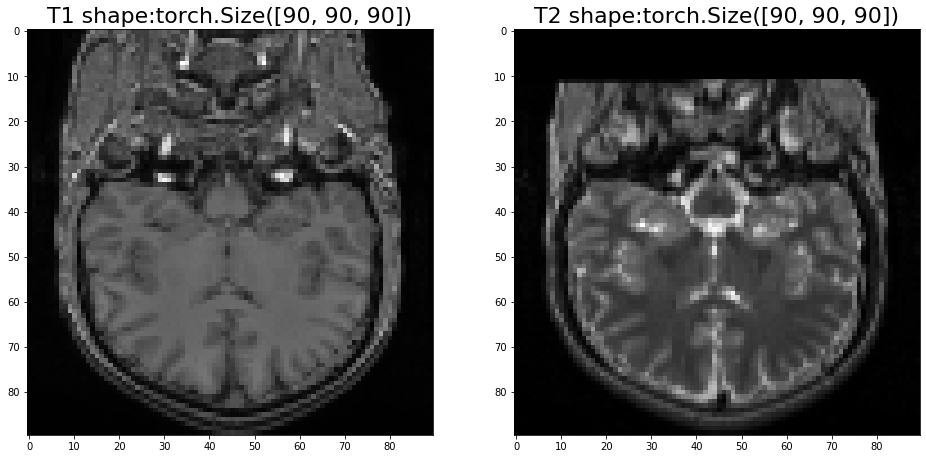

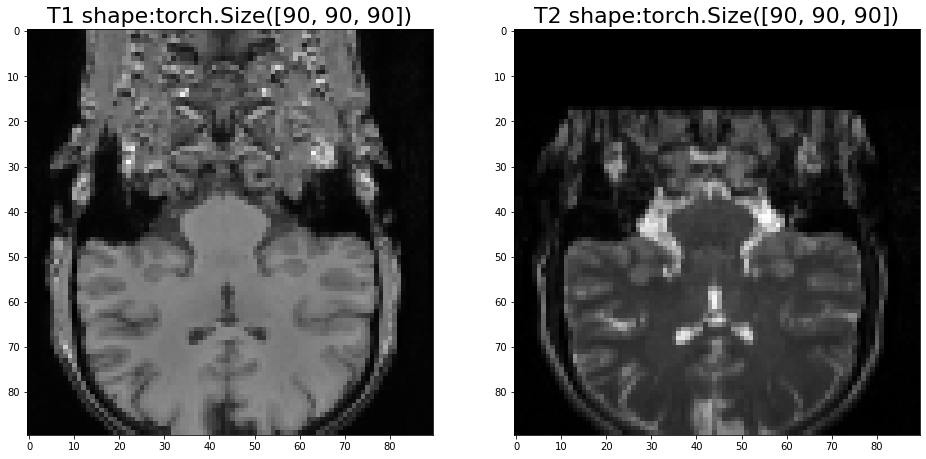

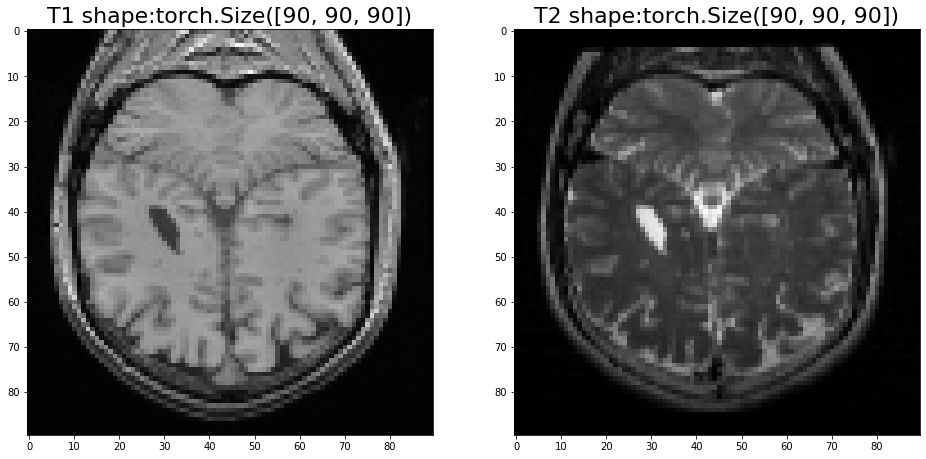

In [316]:
for i in range(len(transformed_nifti_dataset)):
    sample = transformed_nifti_dataset[i]
    
    print(i, len(sample), sample[0].shape, sample[1].shape)
    
    showPairImages(sample[0], sample[1])
    if i == 3:
        break;